## Mod 5 Project
#### Machine Learning Classification
This project is an analysis of a number of Starcraft 2 players. The goal of the project is to classify players into an appropriate league based on their playing statistics and habits.

Database Source: https://www.kaggle.com/danofer/skillcraft/data#SkillCraft.csv

### Imports & Data Inspection/Cleaning

In [156]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

from sklearn import svm, tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')

In [2]:
data = pd.read_csv("SkillCraft.csv")
data.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001194,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [3]:
data.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [4]:
data['GameID'].value_counts()

4094    1
513     1
685     1
4779    1
6826    1
       ..
5300    1
5296    1
7341    1
3243    1
4098    1
Name: GameID, Length: 3338, dtype: int64

In [5]:
#Dropping GameID column as it is just a unique identifier.
data.drop(columns = 'GameID', inplace = True)

### Train/Test Split & Normalization

In [41]:
y = data['LeagueIndex']
X = data.drop(columns = 'LeagueIndex')

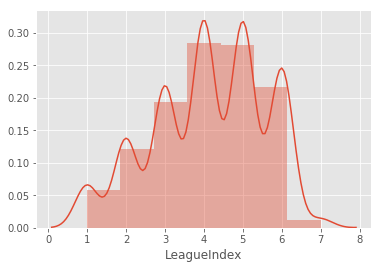

In [7]:
sns.distplot(y, bins = 7)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

In [82]:
sm = SMOTE()
X_train_sample, y_train_sample = sm.fit_resample(X_train, y_train)
X_train_sample = pd.DataFrame(X_train_sample, 
                              columns = X.columns)

In [84]:
scaler = StandardScaler()
X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

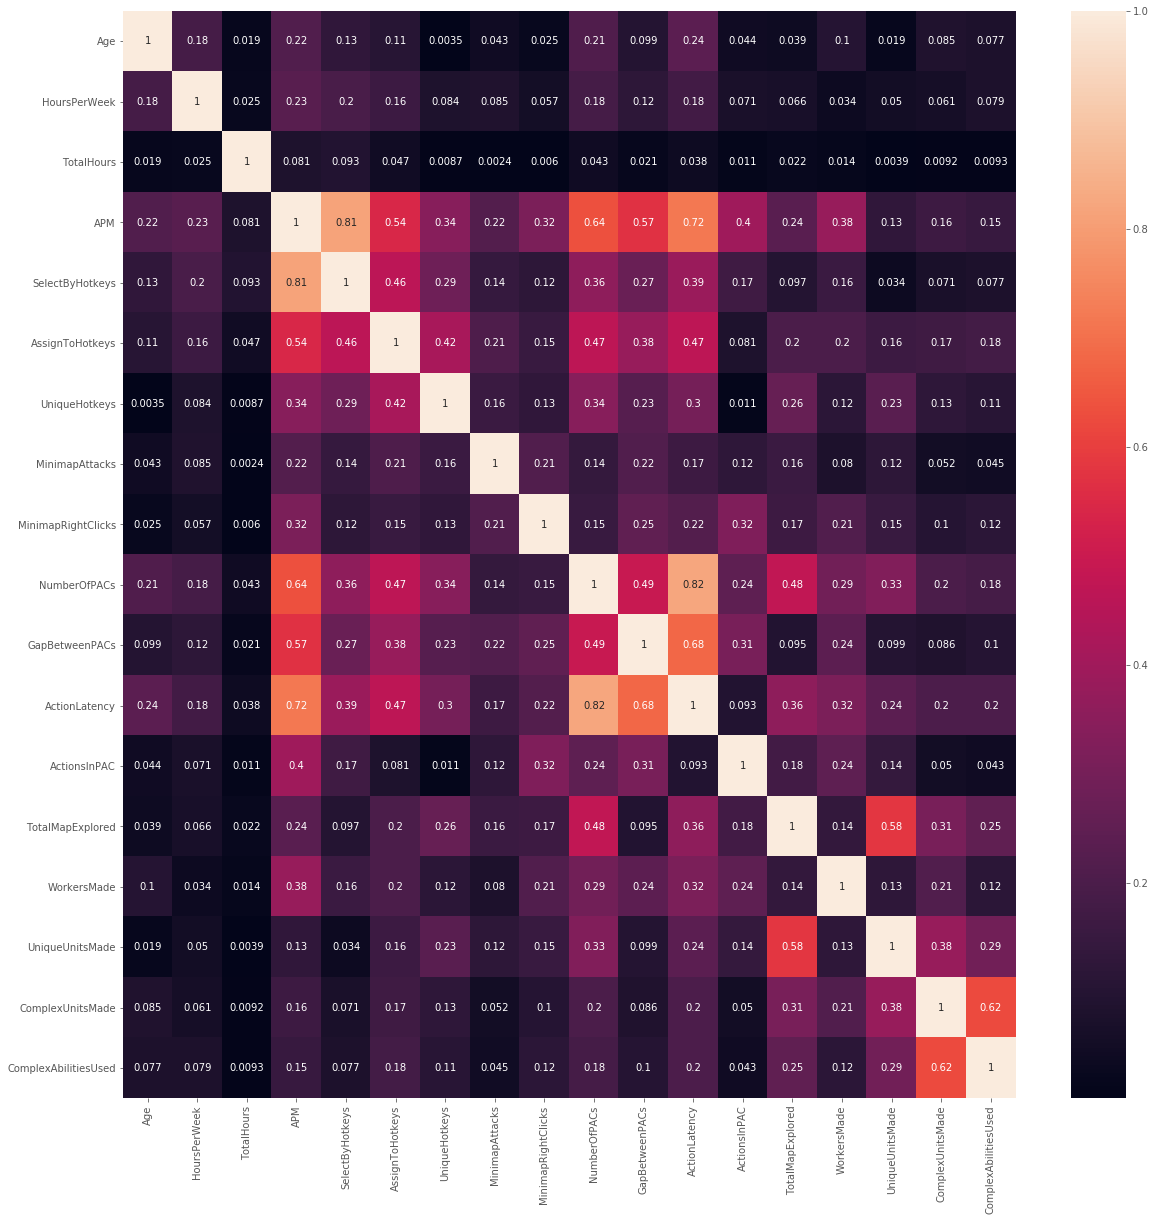

In [85]:
plt.figure(figsize = [20, 20])
sns.heatmap(X_train_scaled.corr().abs(), annot = True)

# Modeling
### Function Creation

In [12]:
def fit_model(clf, X_train, X_test, y_train, y_test,
              param_grid, scoring = 'accuracy', cv = 3,
              feature_importances = None, title = None):
    """
    This function will fit a model using the provided classifier, dataset, 
    and parameter grid. It uses GridSearchCV to determine the best model.
    
    INPUTS:
    clf                 = Classifier to be fit
    X_train,X_test,y_train,y_test = train/test data to be used 
    param_grid          = Parameter grid to be used for the gridsearch
    scoring             = Scoring method to be used for the gridsearch
    cv                  = Number of cross-validations
    feature_importances = Number of top features to print
    title               = Title to print for clarity when reviewing outputs
    
    OUTPUTS:
    Returns the best estimator model from GridSearch. 
    Prints title, score, feature importances to screen.
    """
    grid_clf = GridSearchCV(estimator = clf, param_grid = param_grid, 
                            cv = cv, scoring = scoring)
    grid_clf.fit(X_train, y_train)
    if title:
        print(title)
    print(" BEST PARAMS:")
    print(grid_clf.best_params_)
    print("\nBest", scoring.capitalize() ,"Score:",round(grid_clf.best_score_,4))

    #Get Stats for Train Test Split just to verify that crossvalidation was good.
    print_model_stats(grid_clf, X_train, X_test, y_train, y_test)
    if feature_importances:
        try:
            print("")
            get_feature_importances(grid_clf.best_estimator_, X_train, num_features=feature_importances)
        except:
            pass
    return grid_clf.best_estimator_

In [13]:
def get_feature_importances(estimator, df, num_features=10):
    """
    This function will print the feature importances from the provided model
    and dataframe.
    
    INPUTS:
    estimator    = The model that has been fit.
    df           = The dataframe containing model features.
    num_features = The number of features to print.
    """
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    if len(importances) < num_features:
        num_features = len(importances)
    print("Feature ranking:")
    for idx, f_idx in enumerate(indices[0:num_features]):
        print(f"{idx+1}: Score {round(importances[f_idx],3)}, Feature Name: {df.columns[f_idx]}")
    return

In [14]:
def print_model_stats(estimator, X_train, X_test, y_train, y_test):
    """
    This function prints the accuracy and precision score for the provided
    model using the training and test datasets provided.
    """
    y_pred_train = estimator.predict(X_train)
    y_pred_test  = estimator.predict(X_test)
    print(" TRAINING:  Accuracy:",round(accuracy_score(y_train,y_pred_train),4))
    print(" TEST:      Accuracy:",round(accuracy_score(y_test,y_pred_test),4))   
    return

### Creating Classifiers & Parameter Grids

In [21]:
rf_clf = RandomForestClassifier()
param_grid_rf = [{'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 2, 4, 6, 8, 10],
                  'n_estimators': [50, 100]}]

In [27]:
xgb_clf = XGBClassifier()
param_grid_xgb = [{'max_depth': [2, 3, 4, 5],
                   'n_estimators': [50, 100],
                   'learning_rate': [0.1, 0.2],
                   'gamma': [0, 1] }]

In [17]:
svc_clf = SVC()
param_grid_svc = [{'C': [1.0],
                   'gamma': ['auto'] }]

In [53]:
ovrx_clf = OneVsRestClassifier(XGBClassifier())
param_grid_ovrx = [{'estimator__max_depth': [2, 3, 4, 5],
                   'estimator__n_estimators': [50, 100],
                   'estimator__learning_rate': [0.1, 0.2],
                   'estimator__gamma': [0, 1] }]

In [36]:
ovrs_clf = OneVsRestClassifier(SVC())
param_grid_ovrs = [{'estimator__C': [1.0],
                   'estimator__gamma': ['auto'] }]

### Testing Models

In [86]:
fit_model(rf_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.6637
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.3573

Feature ranking:
1: Score 0.121, Feature Name: ActionLatency
2: Score 0.114, Feature Name: APM
3: Score 0.088, Feature Name: SelectByHotkeys
4: Score 0.075, Feature Name: NumberOfPACs
5: Score 0.074, Feature Name: TotalHours
6: Score 0.068, Feature Name: MinimapAttacks
7: Score 0.067, Feature Name: GapBetweenPACs
8: Score 0.058, Feature Name: AssignToHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
fit_model(xgb_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6282
 TRAINING:  Accuracy: 0.995
 TEST:      Accuracy: 0.3214


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [88]:
fit_model(svc_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5315
 TRAINING:  Accuracy: 0.6473
 TEST:      Accuracy: 0.3463


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [89]:
fit_model(ovrx_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6337
 TRAINING:  Accuracy: 0.9958
 TEST:      Accuracy: 0.3074


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [90]:
fit_model(ovrs_clf, X_train_scaled_sample, X_test_scaled, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5377
 TRAINING:  Accuracy: 0.7267
 TEST:      Accuracy: 0.3034


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### Removing Multi-Colinearity

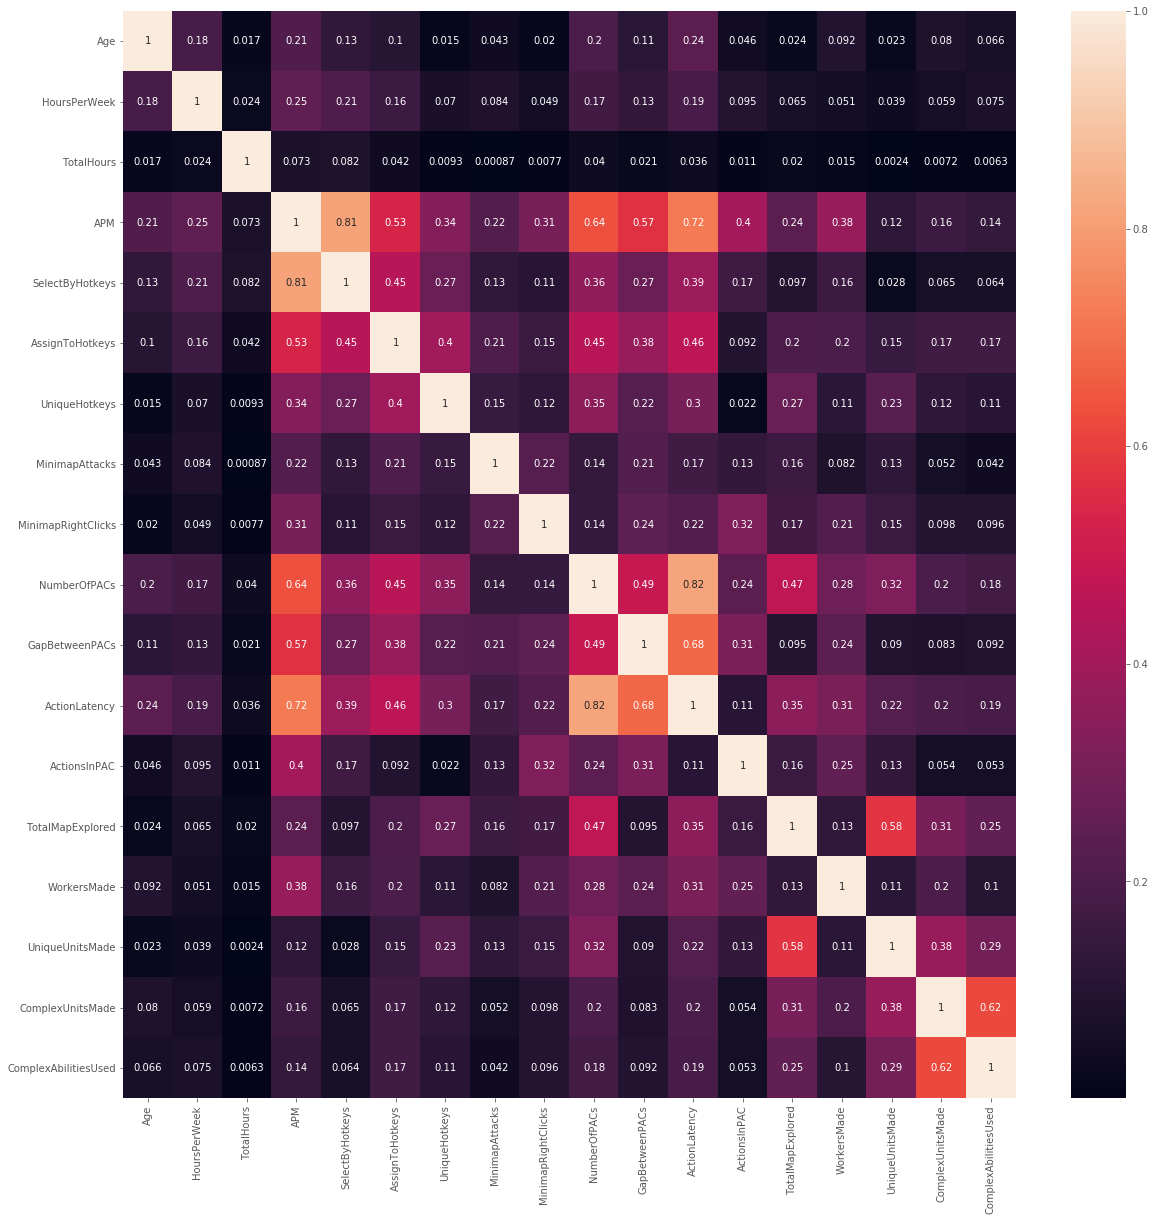

In [38]:
plt.figure(figsize = [20, 20])
sns.heatmap(X.corr().abs(), annot = True)

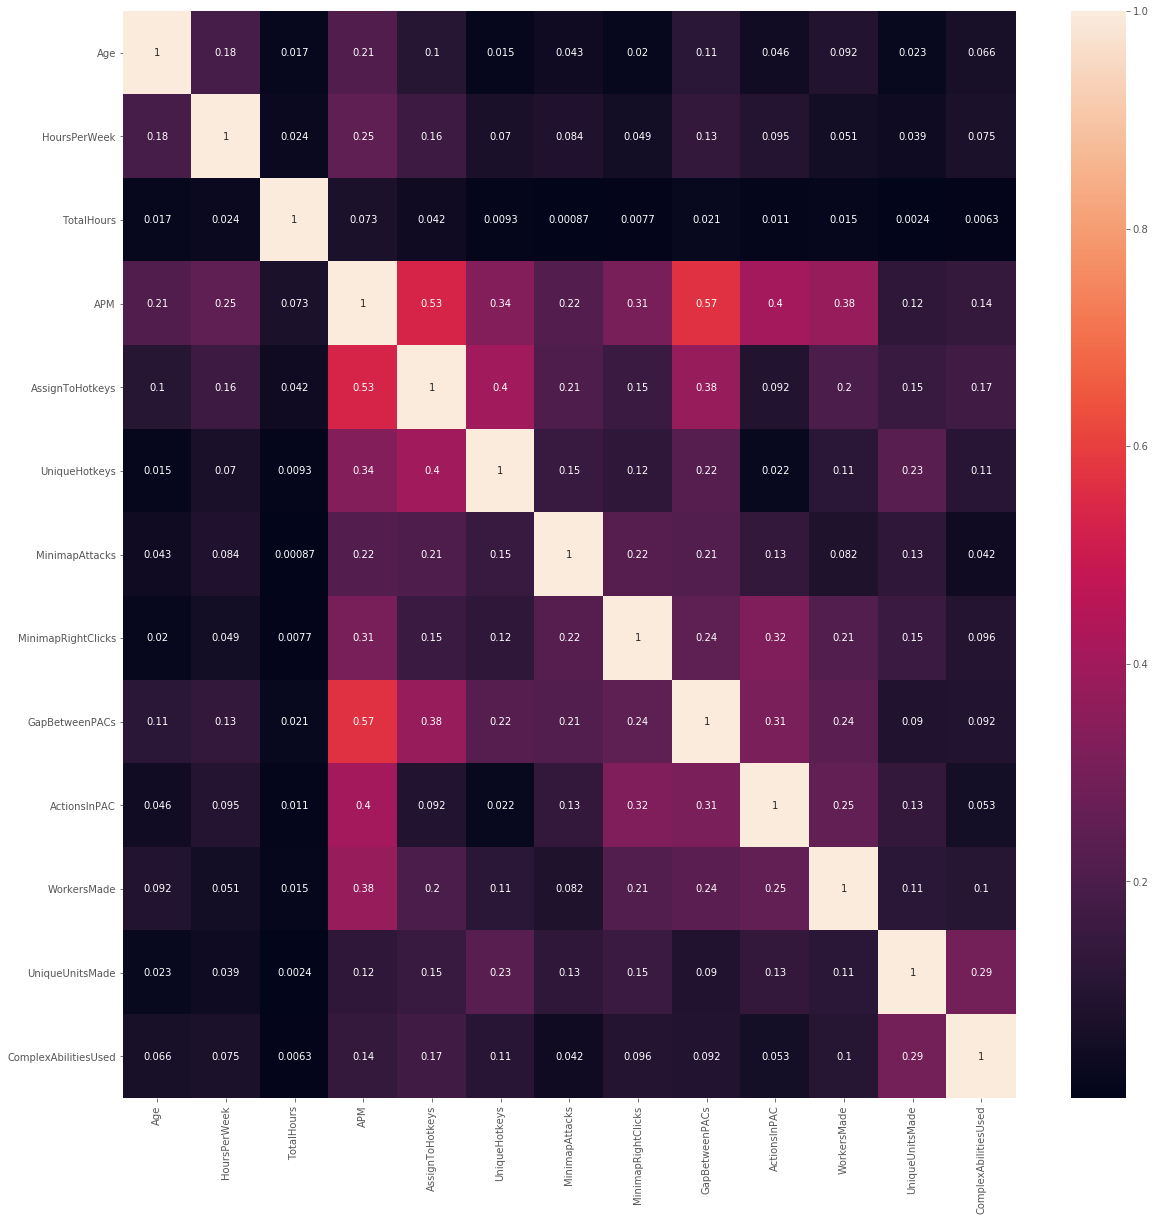

In [70]:
columns_to_remove = ['ActionLatency', 'NumberOfPACs', 'SelectByHotkeys', 
                     'TotalMapExplored', 'ComplexUnitsMade']
X_filtered = X.drop(columns = columns_to_remove)
plt.figure(figsize = [20, 20])
sns.heatmap(X_filtered.corr().abs(), annot = True)

In [71]:
X_filt_train, X_filt_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size = 0.30, random_state = 42)

In [72]:
sm = SMOTE()
X_filt_train_sample, y_train_sample = sm.fit_resample(X_filt_train, y_train)
X_filt_train_sample = pd.DataFrame(X_filt_train_sample, 
                              columns = X_filtered.columns)

In [76]:
scaler = StandardScaler()
X_filt_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_filt_train_sample), 
                              columns = X_filtered.columns, index = X_filt_train_sample.index)
X_filt_test_scaled = pd.DataFrame(scaler.fit_transform(X_filt_test), 
                              columns = X_filtered.columns, index = X_filt_test.index)

In [77]:
fit_model(rf_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.6572
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.3373

Feature ranking:
1: Score 0.149, Feature Name: APM
2: Score 0.099, Feature Name: GapBetweenPACs
3: Score 0.097, Feature Name: AssignToHotkeys
4: Score 0.091, Feature Name: TotalHours
5: Score 0.09, Feature Name: MinimapAttacks
6: Score 0.068, Feature Name: WorkersMade
7: Score 0.067, Feature Name: ActionsInPAC
8: Score 0.066, Feature Name: UniqueHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [78]:
fit_model(xgb_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.5965
 TRAINING:  Accuracy: 0.9883
 TEST:      Accuracy: 0.3024


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [79]:
fit_model(svc_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5171
 TRAINING:  Accuracy: 0.624
 TEST:      Accuracy: 0.3273


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [80]:
fit_model(ovrx_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6044
 TRAINING:  Accuracy: 0.995
 TEST:      Accuracy: 0.2964


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [81]:
fit_model(ovrs_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5161
 TRAINING:  Accuracy: 0.6959
 TEST:      Accuracy: 0.2994


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### PCA

In [91]:
pca = PCA()
X_train_sample_trans = pd.DataFrame(pca.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_trans = pd.DataFrame(pca.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

In [92]:
fit_model(rf_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.6672
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.1737

Feature ranking:
1: Score 0.225, Feature Name: HoursPerWeek
2: Score 0.126, Feature Name: Age
3: Score 0.062, Feature Name: TotalHours
4: Score 0.051, Feature Name: APM
5: Score 0.044, Feature Name: NumberOfPACs
6: Score 0.043, Feature Name: MinimapAttacks
7: Score 0.042, Feature Name: UniqueUnitsMade
8: Score 0.041, Feature Name: GapBetweenPACs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [93]:
fit_model(xgb_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.6255
 TRAINING:  Accuracy: 0.9968
 TEST:      Accuracy: 0.1936


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [94]:
fit_model(svc_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.4303
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.2355


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
fit_model(ovrx_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.6305
 TRAINING:  Accuracy: 0.998
 TEST:      Accuracy: 0.1577


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [96]:
fit_model(ovrs_clf, X_train_sample_trans, X_test_trans, y_train_sample, y_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5074
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.2285


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

# Refinement
As none of our models have had better than about 36% accuracy thus far, the next step will be to try reducing the number of classes down to three (Beginner, Advanced, and Expert). The original classes will be binned as 1-3 (Bronze, Silver, Gold) into Beginner, 4 and 5 (Platinum and Diamond) into Advanced, and 6 and 7 (Master and Grandmaster) into Expert.

In [98]:
y.value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

In [105]:
y_group = y.map(lambda x: 'Beginner' if x in [1, 2, 3] else 
                'Advanced' if x in [4, 5] else 'Expert')
y_group.head()

0    Advanced
1    Advanced
2    Advanced
3    Beginner
4    Beginner
Name: LeagueIndex, dtype: object

In [106]:
y_group.value_counts()

Advanced    1615
Beginner    1067
Expert       656
Name: LeagueIndex, dtype: int64

In [110]:
X_train, X_test, y_group_train, y_group_test = train_test_split(
    X, y_group, test_size = 0.30, random_state = 42)

In [111]:
sm = SMOTE()
X_train_sample, y_group_train_sample = sm.fit_resample(X_train, y_group_train)
X_train_sample = pd.DataFrame(X_train_sample, 
                              columns = X.columns)

In [112]:
scaler = StandardScaler()
X_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

### Initial Models

In [113]:
fit_model(rf_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.7621
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6527

Feature ranking:
1: Score 0.146, Feature Name: ActionLatency
2: Score 0.105, Feature Name: APM
3: Score 0.079, Feature Name: NumberOfPACs
4: Score 0.077, Feature Name: SelectByHotkeys
5: Score 0.07, Feature Name: TotalHours
6: Score 0.07, Feature Name: GapBetweenPACs
7: Score 0.058, Feature Name: AssignToHotkeys
8: Score 0.056, Feature Name: MinimapAttacks


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [117]:
fit_model(xgb_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

Best Accuracy Score: 0.7256
 TRAINING:  Accuracy: 0.8815
 TEST:      Accuracy: 0.5479


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [118]:
fit_model(svc_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.7008
 TRAINING:  Accuracy: 0.7732
 TEST:      Accuracy: 0.6168


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [119]:
fit_model(ovrx_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.7256
 TRAINING:  Accuracy: 0.9924
 TEST:      Accuracy: 0.515


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [120]:
fit_model(ovrs_clf, X_train_scaled_sample, X_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.6912
 TRAINING:  Accuracy: 0.7735
 TEST:      Accuracy: 0.5948


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### Removing Multi-Collinearity
Based on the Feature Ranking from our Random Forest, we'll remove the features with the most collinearity and the least effect.

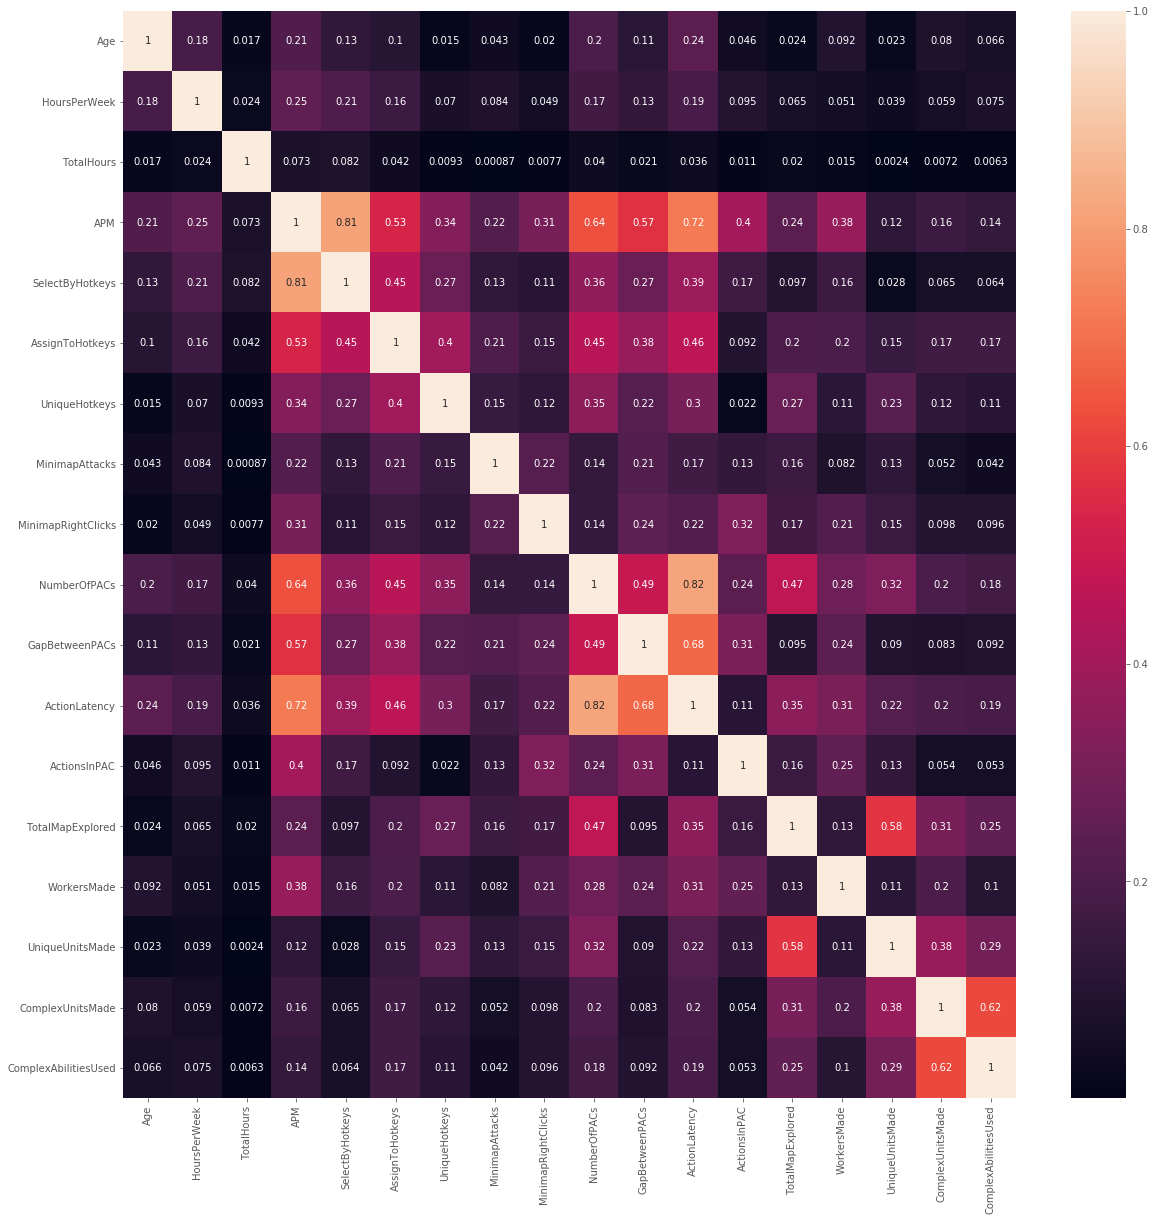

In [122]:
plt.figure(figsize = [20, 20])
sns.heatmap(X.corr().abs(), annot = True)

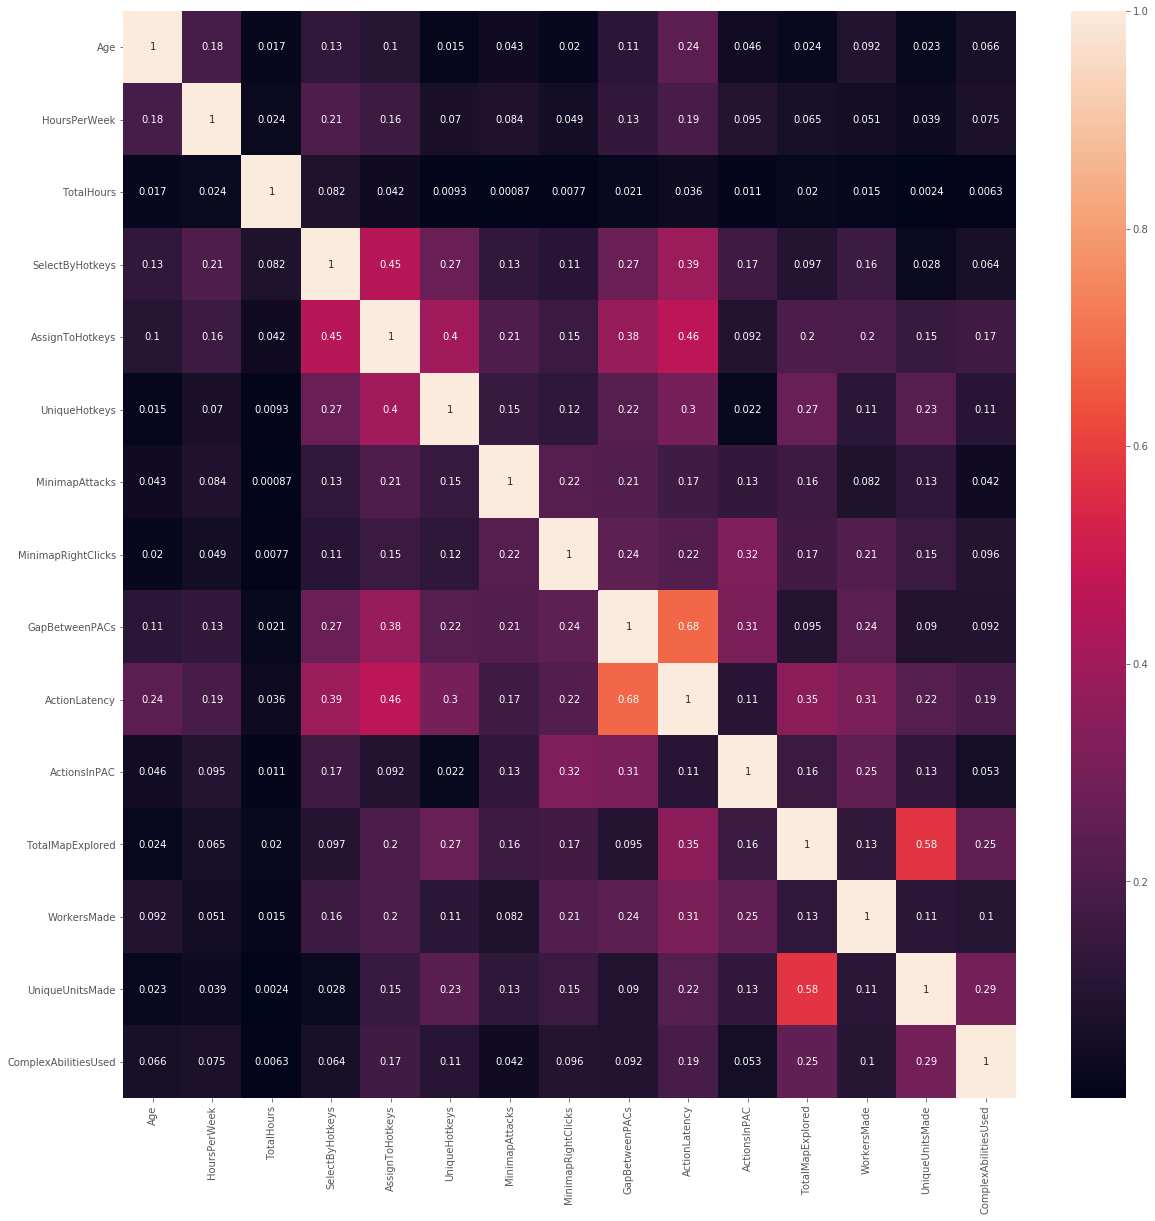

In [123]:
columns_to_remove = ['APM', 'NumberOfPACs', 'ComplexUnitsMade']
X_filtered = X.drop(columns = columns_to_remove)
plt.figure(figsize = [20, 20])
sns.heatmap(X_filtered.corr().abs(), annot = True)

In [124]:
X_filt_train, X_filt_test, y_group_train, y_group_test = train_test_split(
    X_filtered, y_group, test_size = 0.30, random_state = 42)

In [131]:
sm = SMOTE()
X_filt_train_sample, y_group_train_sample = sm.fit_resample(X_filt_train, y_group_train)
X_filt_train_sample = pd.DataFrame(X_filt_train_sample, 
                              columns = X_filtered.columns)

In [132]:
scaler = StandardScaler()
X_filt_train_scaled_sample = pd.DataFrame(scaler.fit_transform(X_filt_train_sample), 
                              columns = X_filtered.columns, index = X_filt_train_sample.index)
X_filt_test_scaled = pd.DataFrame(scaler.fit_transform(X_filt_test), 
                              columns = X_filtered.columns, index = X_filt_test.index)

In [133]:
fit_model(rf_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.7633
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.6607

Feature ranking:
1: Score 0.178, Feature Name: ActionLatency
2: Score 0.115, Feature Name: SelectByHotkeys
3: Score 0.092, Feature Name: TotalHours
4: Score 0.087, Feature Name: GapBetweenPACs
5: Score 0.077, Feature Name: AssignToHotkeys
6: Score 0.071, Feature Name: MinimapAttacks
7: Score 0.053, Feature Name: WorkersMade
8: Score 0.051, Feature Name: UniqueHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [134]:
fit_model(xgb_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

Best Accuracy Score: 0.7274
 TRAINING:  Accuracy: 0.8824
 TEST:      Accuracy: 0.5379


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [135]:
fit_model(svc_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.6959
 TRAINING:  Accuracy: 0.7773
 TEST:      Accuracy: 0.6148


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [136]:
fit_model(ovrx_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 50}

Best Accuracy Score: 0.732
 TRAINING:  Accuracy: 0.8923
 TEST:      Accuracy: 0.5349


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [137]:
fit_model(ovrs_clf, X_filt_train_scaled_sample, X_filt_test_scaled, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.6871
 TRAINING:  Accuracy: 0.7735
 TEST:      Accuracy: 0.5888


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

### PCA

In [138]:
pca = PCA()
X_train_sample_trans = pd.DataFrame(pca.fit_transform(X_train_sample), 
                              columns = X.columns)
X_test_trans = pd.DataFrame(pca.fit_transform(X_test), 
                              columns = X.columns, index = X_test.index)

In [139]:
fit_model(rf_clf, X_train_sample_trans, X_test_trans, y_group_train_sample, y_group_test, 
          param_grid_rf, feature_importances = 8, title = 'Random Forest')

Random Forest
 BEST PARAMS:
{'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}

Best Accuracy Score: 0.7566
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.3363

Feature ranking:
1: Score 0.229, Feature Name: HoursPerWeek
2: Score 0.122, Feature Name: Age
3: Score 0.055, Feature Name: TotalHours
4: Score 0.049, Feature Name: MinimapAttacks
5: Score 0.045, Feature Name: NumberOfPACs
6: Score 0.044, Feature Name: SelectByHotkeys
7: Score 0.044, Feature Name: GapBetweenPACs
8: Score 0.042, Feature Name: UniqueHotkeys


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [140]:
fit_model(xgb_clf, X_train_sample_trans, X_test_trans, y_group_train_sample, y_group_test, 
          param_grid_xgb, title = 'XGBoost')

XGBoost
 BEST PARAMS:
{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

Best Accuracy Score: 0.7434
 TRAINING:  Accuracy: 0.9956
 TEST:      Accuracy: 0.3353


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [141]:
fit_model(svc_clf, X_train_sample_trans, X_test_trans, y_group_train_sample, y_group_test, 
          param_grid_svc, title = 'Support Vector')

Support Vector
 BEST PARAMS:
{'C': 1.0, 'gamma': 'auto'}

Best Accuracy Score: 0.5665
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.4721


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [142]:
fit_model(ovrx_clf, X_train_sample_trans, X_test_trans, y_group_train_sample, y_group_test, 
          param_grid_ovrx, title = 'One Vs Rest XGBoost')

One Vs Rest XGBoost
 BEST PARAMS:
{'estimator__gamma': 0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 100}

Best Accuracy Score: 0.7487
 TRAINING:  Accuracy: 0.9959
 TEST:      Accuracy: 0.3323


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=None)

In [143]:
fit_model(ovrs_clf, X_train_sample_trans, X_test_trans, y_group_train_sample, y_group_test, 
          param_grid_ovrs, title = 'One Vs Rest SVC')

One Vs Rest SVC
 BEST PARAMS:
{'estimator__C': 1.0, 'estimator__gamma': 'auto'}

Best Accuracy Score: 0.5937
 TRAINING:  Accuracy: 1.0
 TEST:      Accuracy: 0.4721


OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

# Results & Conclusion

Thus far, our best model was the Random Forest after reducing our number of classes down to three and removing a number of multi-collinear features.

In [148]:
best_estimator = GridSearchCV(rf_clf, param_grid_rf, cv = 3, scoring = 'accuracy')
best_estimator.fit(X_filt_train_scaled_sample, y_group_train_sample)
y_pred = best_estimator.best_estimator_.predict(X_filt_test_scaled)

Text(0.5, 1.0, 'Random Forest Best Estimator Actual vs Predicted Values')

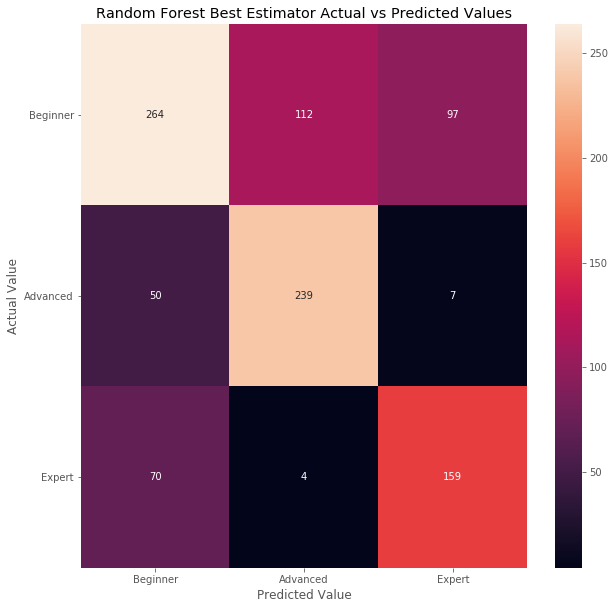

In [176]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(y_group_test, y_pred), annot = True, fmt = 'g', 
            xticklabels = ['Beginner', 'Advanced', 'Expert'], 
            yticklabels = ['Beginner', 'Advanced', 'Expert'])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.yticks(rotation = 0)
plt.title("Random Forest Best Estimator Actual vs Predicted Values")

As you can see from the Confusion Matrix, we're still only about 66% accurate, and tend to miss the Beginner rank the most. This is most likely due to the fact that most players are able to play at a higher tier but aren't able to devote the time to get through the lower ranks of Bronze, Silver, and Gold. 

# Future Work
I would like to continue pushing on this, and figure out a way to adjust for those Beginner tier misclassifications, however I feel like the best way to go about that would be to more heavily weight the TotalHours feature, assuming that it is indeed the reason for those misses. If it's not, I have no idea where to go from there.

I would also like to eventually take each tier and create a model to further classify them back down into each league, if possible. The hardest tier to do would likely be Expert as the Grandmaster tier is very small by comparison.